# Import statements

In [1]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import utils

# Parse oracle_throughputs.json file

In [3]:
import json
def read_all_throughputs_json(throughputs_file):
    with open(throughputs_file, 'r') as f:
        throughputs = json.load(f)
    return throughputs

In [4]:
throughputs = read_all_throughputs_json("oracle_throughputs.json")
isolated_throughputs = {}
models = []
for worker_type in throughputs:
    isolated_throughputs[worker_type] = {}
    for model in throughputs[worker_type]:
        models.append(model)
        isolated_throughputs[worker_type][model] = \
            throughputs[worker_type][model]['null']
models = sorted(list(set(models)))
worker_types = ['k80', 'p100', 'v100']
on_demand_prices = {
    'k80': 0.52,
    'p100': 1.68,
    'v100': 2.85,
}

# Simulate cost savings with various sources of price variation

In [5]:
from datetime import datetime
from datetime import timedelta
import os

aws_instances = {
    "p2.xlarge": ("k80", 1),
    "p2.8xlarge": ("k80", 8),
    "p2.16xlarge": ("k80", 16),
    "p3.2xlarge": ("v100", 1),
    "p3.8xlarge": ("v100", 4),
    "p3.16xlarge": ("v100", 8),
}

azure_instance_mapping = utils.read_azure_instance_mapping_file(
    "../logs/azure/instance_mapping.csv")
azure_inverse_instance_mapping = {}
for k, v in azure_instance_mapping.items():
    azure_inverse_instance_mapping[v] = k

def get_spot_price(aws_per_instance_type_spot_prices,
                   gcp_per_instance_type_spot_prices,
                   azure_per_instance_type_spot_prices,
                   timestamp, instance_type, availability_zone, cloud_provider):
    if cloud_provider == 'aws':
        for x in aws_per_instance_type_spot_prices[instance_type]:
            x_timestamp = x['Timestamp']
            spot_price = float(x['SpotPrice'])
            (_, num_gpus) = aws_instances[instance_type]
            if x_timestamp == timestamp and x['AvailabilityZone'] == availability_zone:
                return spot_price
    elif cloud_provider == 'azure':
        gpu_type = instance_type[0]
        num_gpus = instance_type[1]
        azure_instance_type = azure_inverse_instance_mapping[instance_type]
        for x in azure_per_instance_type_spot_prices[azure_instance_type]:
            if x[0] == availability_zone and x[1] == timestamp and x[2] != "":
                spot_price = float(x[2].replace("$", ""))
                return spot_price
    elif cloud_provider == 'gcp':
        # TODO: Fill this out.
        pass
    

def decode_strategy(timestamp,
                    model,
                    strategy,
                    aws_per_instance_type_spot_prices,
                    gcp_per_instance_type_spot_prices,
                    azure_per_instance_type_spot_prices):
    # Return cheapest instance available at the passed-in timestamp, while taking
    # into account the right strategy.
    
    returned_instance_type = None
    returned_availability_zone = None
    cloud_provider = 'aws'
    spot_price = None
    returned_gpu_type = 'v100'
    returned_num_gpus = 1
    returned_spot_price = None
    if strategy == 'baseline':
        # Pick currently cheapest p3.2xlarge instance.
        returned_instance_type = 'p3.2xlarge'
        lowest_price = None
        for x in aws_per_instance_type_spot_prices[returned_instance_type]:
            x_timestamp = x['Timestamp']
            spot_price = float(x['SpotPrice'])
            if x_timestamp == timestamp:
                if lowest_price is None or lowest_price > spot_price:
                    lowest_price = spot_price
                    returned_availability_zone = x['AvailabilityZone']
                    returned_spot_price = spot_price
    elif strategy == 'baseline_worst':
        # Pick currently most expensive p3.2xlarge instance.
        returned_instance_type = 'p3.2xlarge'
        highest_price = None
        for x in aws_per_instance_type_spot_prices[returned_instance_type]:
            x_timestamp = x['Timestamp']
            returned_spot_price = x['SpotPrice']
            if x_timestamp == timestamp:
                if highest_price is None or highest_price < spot_price:
                    highest_price = spot_price
                    returned_availability_zone = x['AvailabilityZone']
                    returned_spot_price = spot_price
    elif strategy == 'gpu_type' or strategy == 'packed' or strategy == 'preemption' \
        or strategy == 'multi_cloud' or strategy == 'preemption_data_movement':
        # Pick instance with highest normalized throughput (which will give us
        # the cheapest instance).
        highest_normalized_throughput = None
        instance_types = [
            'p2.xlarge', 'p2.8xlarge', 'p2.16xlarge',
            'p3.2xlarge', 'p3.8xlarge', 'p3.16xlarge']
        if strategy == 'gpu_type':
            instance_types = ['p2.xlarge', 'p3.2xlarge']
        for x in instance_types:
            (gpu_type, num_gpus) = aws_instances[x]
            for y in aws_per_instance_type_spot_prices[x]:
                y_timestamp = y['Timestamp']
                spot_price = float(y['SpotPrice'])
                normalized_throughput = isolated_throughputs[gpu_type][model] / (spot_price / num_gpus)
                if y_timestamp == timestamp:
                    if highest_normalized_throughput is None or \
                        highest_normalized_throughput < normalized_throughput:
                        highest_normalized_throughput = normalized_throughput
                        returned_instance_type = x
                        returned_availability_zone = y['AvailabilityZone']
                        returned_gpu_type = gpu_type
                        returned_num_gpus = num_gpus
                        returned_spot_price = spot_price

        if strategy == 'multi_cloud' or strategy == 'preemption_data_movement' or strategy == 'preemption':
            # Include Auzre instances as well.
            instance_types = [
                ('nvidia-tesla-v100', 1), ('nvidia-tesla-v100', 2),
                ('nvidia-tesla-v100', 4), ('nvidia-tesla-v100', 8),
                ('nvidia-tesla-p100', 1), ('nvidia-tesla-p100', 2),
                ('nvidia-tesla-p100', 4),
                ('nvidia-tesla-k80', 1), ('nvidia-tesla-k80', 2),
                ('nvidia-tesla-k80', 4), ('nvidia-tesla-k80', 8),
            ]

            for instance_type in instance_types:
                instance_type = (instance_type[0].replace("nvidia-tesla-", ""), instance_type[1])
                gpu_type = instance_type[0]
                num_gpus = instance_type[1]
                if instance_type in azure_inverse_instance_mapping:
                    azure_instance_type = azure_inverse_instance_mapping[instance_type]
                    for x in azure_per_instance_type_spot_prices[azure_instance_type]:

                        if x[1] == timestamp:
                            if x[2] != "":
                                spot_price = float(x[2].replace("$", ""))
                                normalized_throughput = isolated_throughputs[gpu_type][model] / spot_price
                                if highest_normalized_throughput is None or \
                                    highest_normalized_throughput < normalized_throughput:
                                    highest_normalized_throughput = normalized_throughput
                                    returned_instance_type = instance_type
                                    returned_availability_zone = x[0]
                                    returned_gpu_type = gpu_type
                                    returned_num_gpus = num_gpus
                                    returned_spot_price = spot_price
                                    cloud_provider = "azure"

    return (returned_instance_type, returned_availability_zone, returned_gpu_type,
            returned_num_gpus, cloud_provider, returned_spot_price)

def get_max_timestamp(per_instance_type_spot_prices, instance_type):
    timestamps = [x['Timestamp'] for x in per_instance_type_spot_prices[instance_type]]
    timestamps.sort()
    return timestamps[-1]

def get_price(strategy,
              num_days,
              aws_per_instance_type_spot_prices,
              gcp_per_instance_type_spot_prices,
              azure_per_instance_type_spot_prices,
              model,
              start_timestamp, verbose=False):
    
    (instance_type, availability_zone, gpu_type,
     num_gpus, cloud_provider, spot_price) = decode_strategy(
        start_timestamp,
        model,
        strategy,
        aws_per_instance_type_spot_prices,
        gcp_per_instance_type_spot_prices,
        azure_per_instance_type_spot_prices)
    

    max_timestamp = get_max_timestamp(aws_per_instance_type_spot_prices, 'p3.2xlarge')

    num_iterations = (3600 * 24 * num_days) * \
        isolated_throughputs['v100'][model]
    
    for x in aws_per_instance_type_spot_prices:
        aws_per_instance_type_spot_prices[x].sort(
            key=lambda y: y['Timestamp'])

    iterations_done = 0
    cost = 0.0
    current_timestamp = start_timestamp

    i = -1
    last_i_per_instance_type = {}
    for x in aws_per_instance_type_spot_prices:
        last_i_per_instance_type[x] = -1
    while iterations_done < num_iterations and current_timestamp < max_timestamp:
        if verbose:
            print(current_timestamp, iterations_done, instance_type,
                  availability_zone, gpu_type, num_gpus, cloud_provider,
                  spot_price, cost)
        spot_price = float(spot_price)
        next_timestamp = current_timestamp + timedelta(days=1)
        throughput = isolated_throughputs[gpu_type][model]

        if next_timestamp is not None:
            time_between_timestamps = (next_timestamp -
                                       current_timestamp).total_seconds()
            iterations_done_between_timestamps = \
                throughput * time_between_timestamps
            current_timestamp = next_timestamp
        else:
            iterations_done_between_timestamps = \
                num_iterations - iterations_done
        iterations_left = num_iterations - iterations_done
        if iterations_left > iterations_done_between_timestamps:
            iterations_done += iterations_done_between_timestamps
            cost += (time_between_timestamps / 3600) * (spot_price / num_gpus)
        else:
            iterations_done = num_iterations
            cost += ((iterations_left) / (3600.0 * throughput)) * \
                (spot_price / num_gpus)
            if strategy == 'preemption_data_movement':
                return cost+9
            return cost
        if strategy == 'preemption' or strategy == 'preemption_data_movement':
            # If using a strategy that supports preemption, determine if optimal
            # instance type has changed in the last day.
            (instance_type, availability_zone, gpu_type,
             num_gpus, cloud_provider, spot_price) = decode_strategy(
                current_timestamp,
                model,
                strategy,
                aws_per_instance_type_spot_prices,
                gcp_per_instance_type_spot_prices,
                azure_per_instance_type_spot_prices)
            if instance_type in last_i_per_instance_type:
                i = last_i_per_instance_type[instance_type]
        else:
            last_spot_price = spot_price
            # Price for desired instance type might have changed in the last day.
            spot_price = get_spot_price(
                aws_per_instance_type_spot_prices,
                gcp_per_instance_type_spot_prices,
                azure_per_instance_type_spot_prices,
                current_timestamp, instance_type, availability_zone, cloud_provider  
            )
            if spot_price is None:
                spot_price = last_spot_price

    # Reduce the number of iterations left, and update cost thus far.
    iterations_left = num_iterations - iterations_done
    if iterations_left != 0:
        spot_price = float(spot_price)
        cost += ((iterations_left) / (3600.0 * isolated_throughputs[gpu_type][model])) * \
            (spot_price / num_gpus)
        if verbose:
            print(current_timestamp, iterations_done, instance_type,
                  availability_zone, gpu_type, num_gpus, cloud_provider,
                  spot_price, cost)
    return cost

def plot_prices(aws_per_instance_type_spot_prices,
                gcp_per_instance_type_spot_prices,
                azure_per_instance_type_spot_prices,
                num_days=3,
                output_directory=None):
    all_timestamps = []
    for instance_type in aws_per_instance_type_spot_prices:
        all_timestamps.extend(
            [x['Timestamp']
             for x in aws_per_instance_type_spot_prices[instance_type]])
    all_timestamps.sort()
    first_timestamp = all_timestamps[0]
    
    strategy_labels = {
        'baseline': "Best 1xV100",
        'baseline_worst': "Worst 1xV100",
        'gpu_type': "+ GPU type (initial)",
        'packed': "+ multi-GPU",
        'preemption': "+ dynamic",
        'multi_cloud': "+ multi-cloud"
    }
    
    price_statistics = {}
    for model in ['A3C', 'CycleGAN', 'LM (batch size 40)',
                  'LM (batch size 80)',
                  'Recommendation (batch size 8192)',
                  'ResNet-18 (batch size 16)',
                  'ResNet-18 (batch size 256)',
                  'ResNet-50 (batch size 128)',
                  'ResNet-50 (batch size 16)',
                  'Transformer (batch size 16)',
                  'Transformer (batch size 256)']:
        print(model)
        price_statistics[model] = {}
    
        plt.figure(figsize=(6, 3.5))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

        instance_type = 'p3.2xlarge'

        timestamps = set()
        for x in aws_per_instance_type_spot_prices[instance_type]:
            timestamps.add(x['Timestamp'])
        timestamps = list(timestamps)
        timestamps.sort()
        timestamps = timestamps[-35:-5]
        first_timestamp = timestamps[0]

        for strategy in ['baseline_worst', 'baseline', 'gpu_type',
                         'packed', 'multi_cloud', 'preemption']:
            # Plot costs of the different strategies versus time.
            prices = [get_price(
                        strategy,
                        num_days=num_days,
                        aws_per_instance_type_spot_prices=aws_per_instance_type_spot_prices,
                        gcp_per_instance_type_spot_prices=gcp_per_instance_type_spot_prices,
                        azure_per_instance_type_spot_prices=azure_per_instance_type_spot_prices,
                        model=model,
                        start_timestamp=x)
                      for x in timestamps]
            average_price = np.mean(prices)
            max_price = np.max(prices)
            min_price = np.min(prices)
            price_statistics[model][strategy] = (average_price, min_price, max_price, prices)
            print("%s\t%.2f\t%.2f\t%.2f" % (strategy, average_price, min_price, max_price))
            ax.plot([(timestamp - first_timestamp).total_seconds() / (3600 * 24)
                     for timestamp in timestamps],
                    prices, marker='|',
                    label=strategy_labels[strategy])

        ax.set_ylabel("Price ($)")
        ax.set_xlabel("Time (days)")
        ax.set_ylim([0, None])
        ax.set_xlim([0, None])
        sns.despine()

        leg = plt.figlegend(ncol=2, frameon=False, labelspacing=0.25,
                            columnspacing=0.8, handlelength=1.5,
                            loc='upper center')

        bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
        y_offset = 0.43
        bb.y0 += y_offset
        bb.y1 += y_offset
        leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
        
        if output_directory is not None:
            output_filename = os.path.join(
                output_directory,
                model.replace(" (batch size ", "_batch_size=").replace(
                    ")", "").lower() + ".pdf")
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')

        plt.show()
    return price_statistics

In [6]:
def plot_bar_chart(price_statistics, model_labels, strategies, output_filename=None):
    plt.figure(figsize=(30, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.1f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        size=20)

    
    models = [model_label.replace('\n', ' ') for model_label in model_labels]
    
    strategy_labels = {
        'baseline': "1xV100 (AWS)",
        'gpu_type': "+ GPU type (AWS)",
        'packed': "+ multi-GPU (AWS)",
        'preemption': "+ dynamic (AWS/Azure)",
        'multi_cloud': "+ multi-cloud (AWS/Azure)"
    }
    
    offset = 0
    patterns = ('////', '++', 'xx', 'xxx')
    print("\t\t%s" % ("\t".join(models)))
    for i, strategy in enumerate(strategies):
        row = [price_statistics[model][strategies[0]][0] / price_statistics[model][strategy][0]
               for model in models]
        print("%s\t%s" % (strategy, "\t".join(["%.2f" % row_elem for row_elem in row])))
        offsets = [(1.2 * i * len(strategies)) + offset for i in range(len(row))]
        if i == 4:
            rects = ax.bar(offsets, row, label=strategy_labels[strategy])
        else:
            rects = ax.bar(offsets, row, label=strategy_labels[strategy], hatch=patterns[i])
        autolabel(rects)
        offset += 0.8

    ax.set_ylabel("Cost reduction")
    ax.set_ylim([0, None])
    ax.set_xticks([
        (1.2 * i * len(strategies)) + (offset / 2) - 0.4 for i in range(len(row))])
    ax.set_xticklabels([
        model_label.replace("batch size ", "bs=") for model_label in model_labels])
    sns.despine()

    leg = plt.figlegend(loc='upper center', ncol=5,
                        frameon=False, labelspacing=0.25,
                        columnspacing=0.8, handlelength=1.5,
                        handletextpad=0.4)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    yOffset = 0.1
    xOffset = 0
    bb.y0 += yOffset
    bb.y1 += yOffset
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
        
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
        
    plt.show()

A3C
baseline_worst	97.58	93.43	111.90
baseline	95.52	90.83	96.85
gpu_type	72.20	69.97	74.93
packed	55.73	55.73	55.75
multi_cloud	30.78	24.54	55.73
preemption	27.08	24.54	46.30


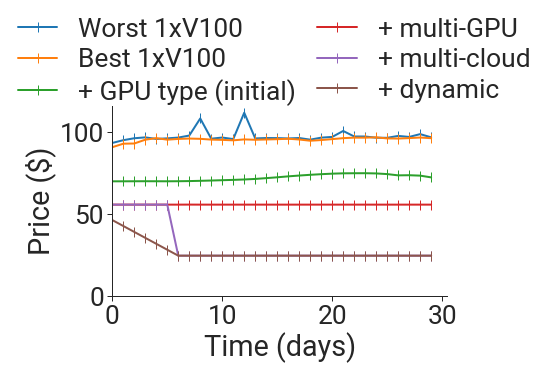

CycleGAN
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	88.13	88.13	88.13
multi_cloud	62.10	49.73	88.13
preemption	58.21	49.73	88.13


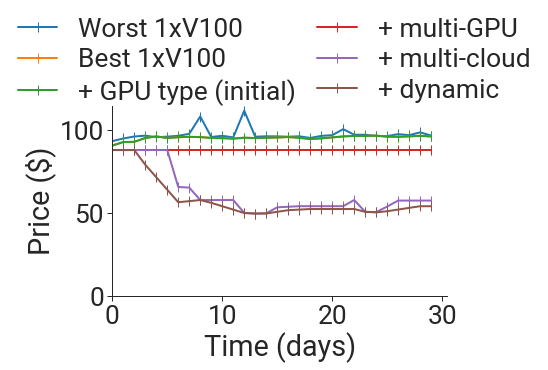

LM (batch size 40)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	88.13	88.13	88.13
multi_cloud	56.35	41.50	88.13
preemption	53.00	41.50	88.13


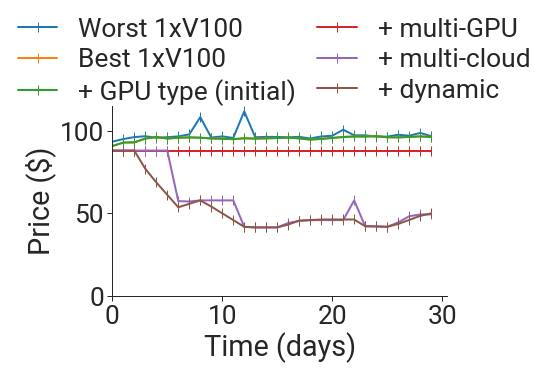

LM (batch size 80)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	88.13	88.13	88.13
multi_cloud	56.14	41.20	88.13
preemption	52.80	41.20	88.13


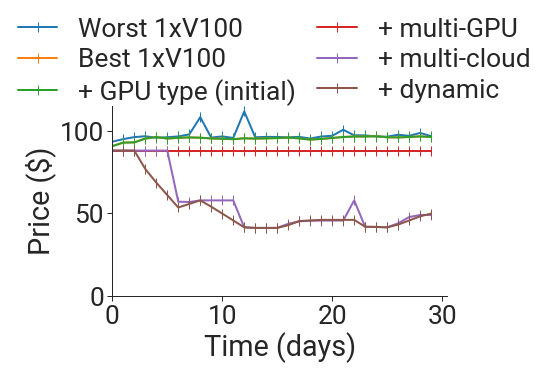

Recommendation (batch size 8192)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	94.48	90.83	97.14
packed	72.76	72.74	72.99
multi_cloud	40.17	32.03	72.74
preemption	34.57	32.03	53.79


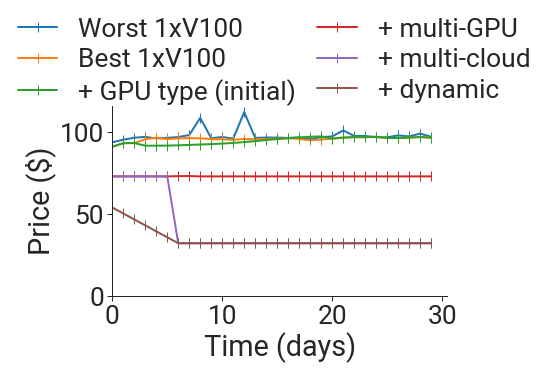

ResNet-18 (batch size 16)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	88.13	88.13	88.13
multi_cloud	54.94	41.55	88.13
preemption	49.57	41.55	88.13


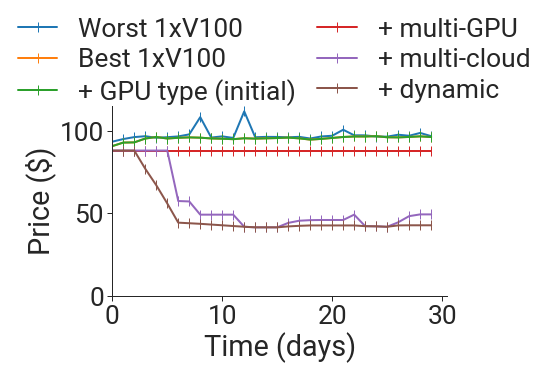

ResNet-18 (batch size 256)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	88.13	88.13	88.13
multi_cloud	56.89	42.27	88.13
preemption	53.50	42.27	88.13


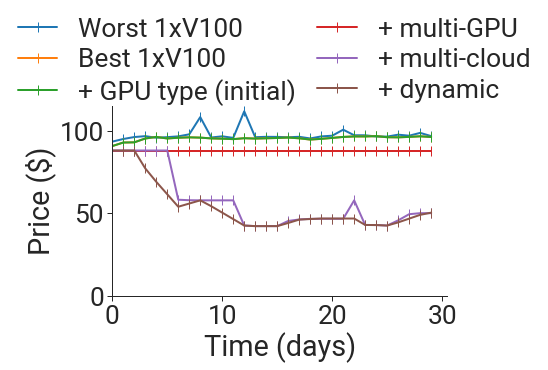

ResNet-50 (batch size 128)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	88.13	88.13	88.13
multi_cloud	63.95	57.90	88.13
preemption	62.43	57.90	88.13


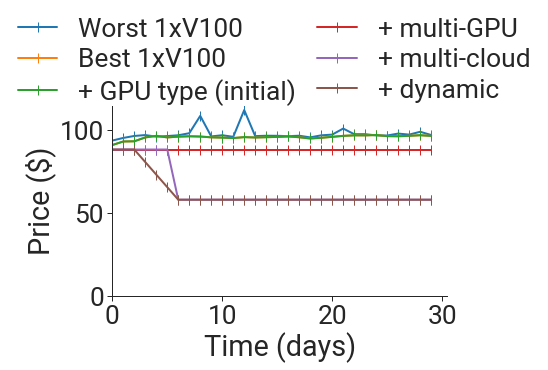

ResNet-50 (batch size 16)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	88.13	88.13	88.13
multi_cloud	64.40	53.01	88.13
preemption	60.14	53.01	88.13


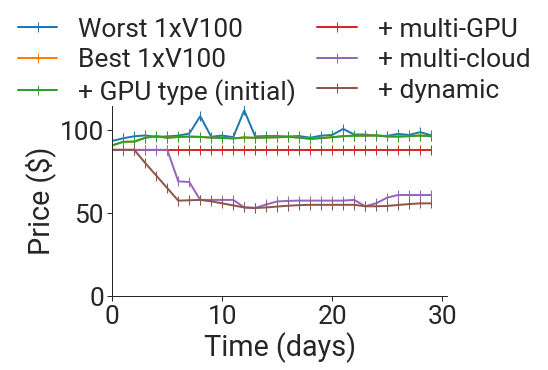

Transformer (batch size 16)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	78.29	75.83	81.09
packed	60.41	60.41	60.48
multi_cloud	33.36	26.60	60.41
preemption	29.14	26.60	48.36


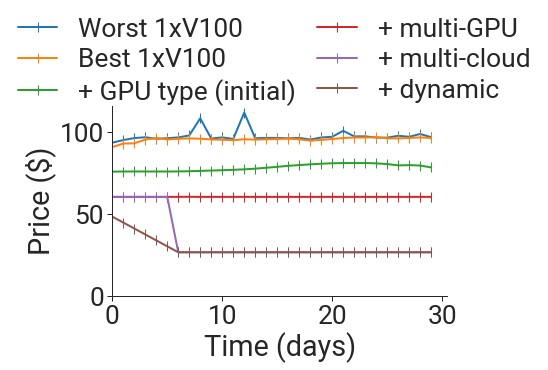

Transformer (batch size 256)
baseline_worst	97.58	93.51	111.90
baseline	95.52	90.83	96.85
gpu_type	95.52	90.83	96.85
packed	85.97	85.95	86.31
multi_cloud	40.44	24.74	85.95
preemption	29.72	24.74	53.76


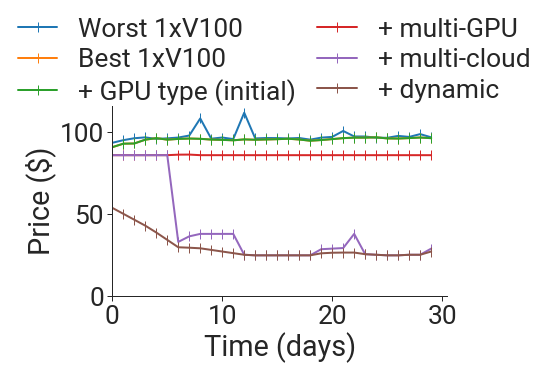

		A3C	CycleGAN	LM (batch size 80)	Recommendation (batch size 8192)	ResNet-50 (batch size 128)	Transformer (batch size 256)
baseline	1.00	1.00	1.00	1.00	1.00	1.00
gpu_type	1.32	1.00	1.00	1.01	1.00	1.00
packed	1.71	1.08	1.08	1.31	1.08	1.11
multi_cloud	3.10	1.54	1.70	2.38	1.49	2.36
preemption	3.53	1.64	1.81	2.76	1.53	3.21


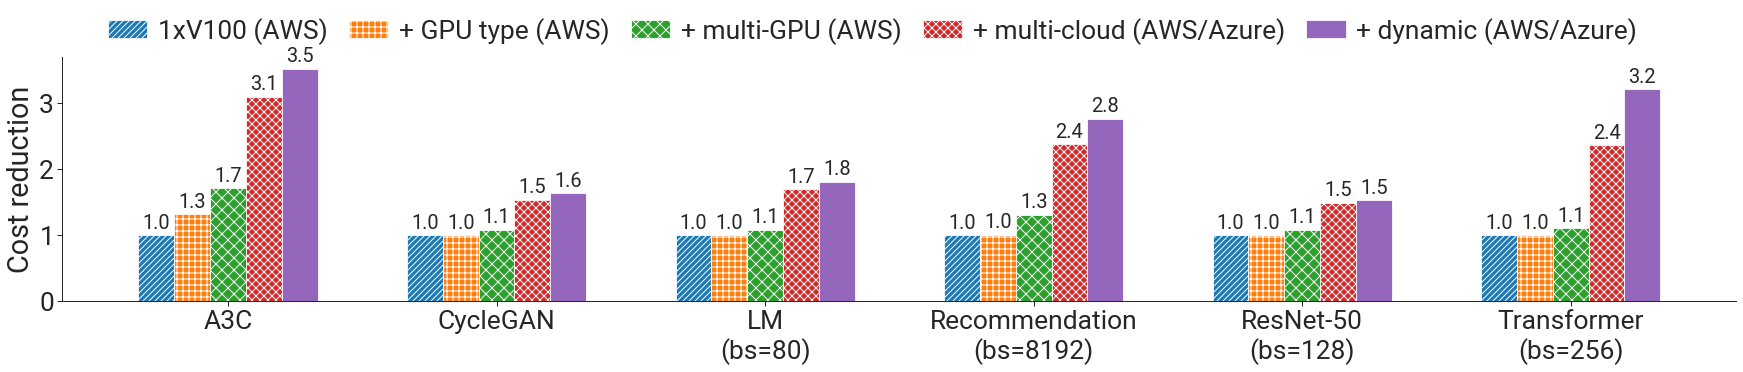

In [7]:
price_statistics = plot_prices(utils.read_aws_prices("../logs/aws/cost/us-east-1", summary=False),
                               utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down"),
                               utils.read_azure_prices("../logs/azure/cost"),
                               num_days=4,
                               output_directory="../graphs/single_job_cost_analysis/per_model_over_time/us_east_1")
strategies = ['baseline', 'gpu_type', 'packed', 'multi_cloud', 'preemption']
model_labels = ['A3C', 'CycleGAN',
                'LM\n(batch size 80)',
                'Recommendation\n(batch size 8192)',
                'ResNet-50\n(batch size 128)',
                'Transformer\n(batch size 256)']
plot_bar_chart(price_statistics, model_labels, strategies,
               output_filename="../graphs/single_job_cost_analysis/average_cost_reduction/us_east_1.pdf")

A3C
baseline_worst	195.49	189.82	225.13
baseline	191.88	185.94	194.94
gpu_type	144.99	140.38	147.56
packed	111.49	111.46	111.85
multi_cloud	61.56	49.08	111.46
preemption	51.62	49.08	70.84


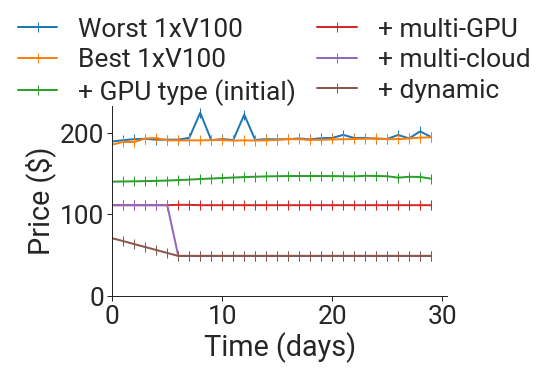

CycleGAN
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	176.26	176.26	176.26
multi_cloud	123.33	103.91	176.26
preemption	111.72	102.20	159.81


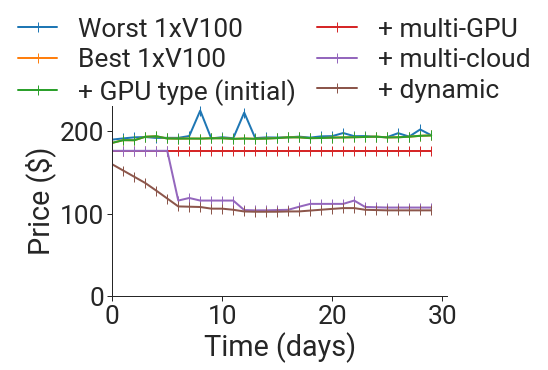

LM (batch size 40)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	176.26	176.26	176.26
multi_cloud	112.08	87.47	176.26
preemption	100.68	87.81	156.96


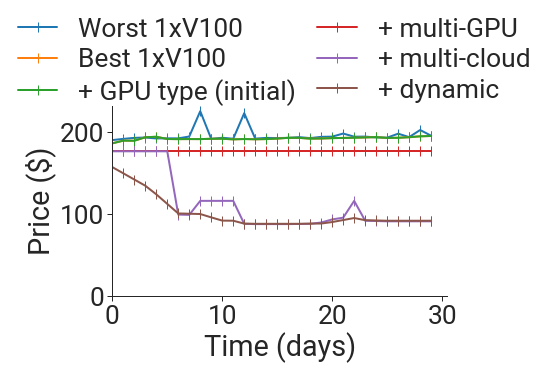

LM (batch size 80)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	176.26	176.26	176.26
multi_cloud	111.68	86.87	176.26
preemption	100.26	87.29	156.84


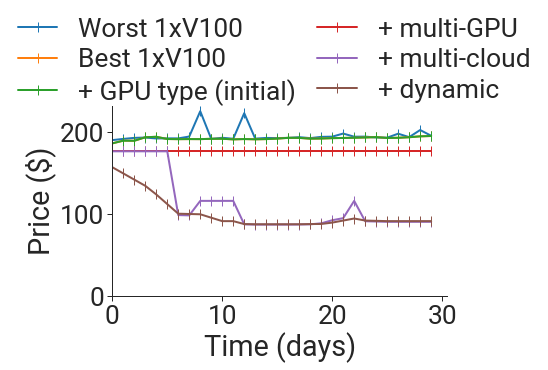

Recommendation (batch size 8192)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	190.71	185.94	194.94
packed	145.51	145.49	145.87
multi_cloud	80.35	64.06	145.49
preemption	66.60	64.06	85.82


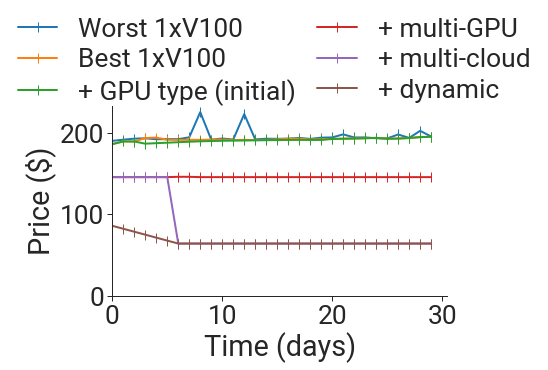

ResNet-18 (batch size 16)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	176.26	176.26	176.26
multi_cloud	109.26	87.56	176.26
preemption	93.29	84.25	155.23


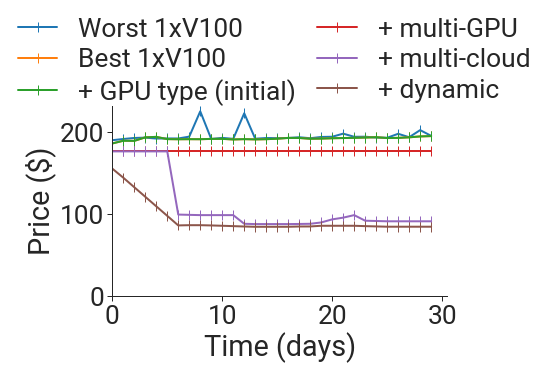

ResNet-18 (batch size 256)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	176.26	176.26	176.26
multi_cloud	113.12	89.00	176.26
preemption	101.74	89.16	157.28


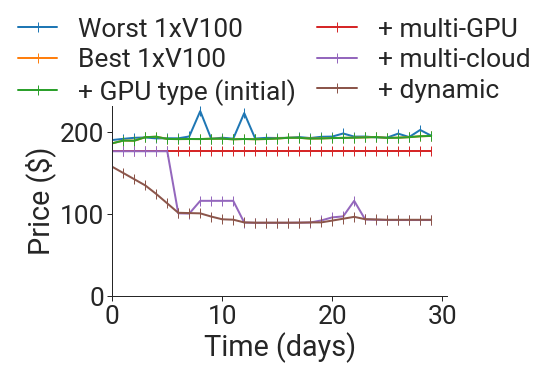

ResNet-50 (batch size 128)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	176.26	176.26	176.26
multi_cloud	127.89	115.80	176.26
preemption	121.09	115.80	161.14


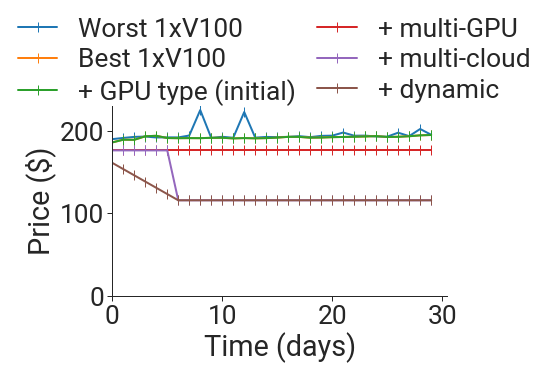

ResNet-50 (batch size 16)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	176.26	176.26	176.26
multi_cloud	127.90	110.53	176.26
preemption	115.90	107.95	160.71


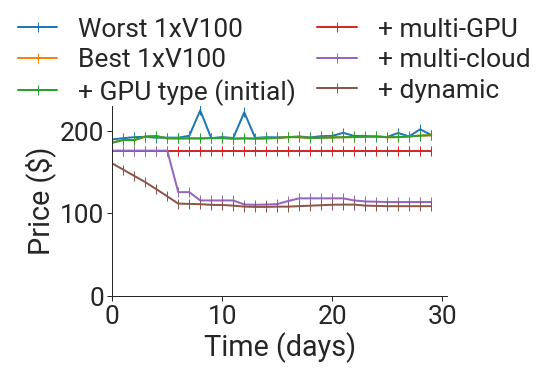

Transformer (batch size 16)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	157.24	152.44	159.76
packed	120.85	120.82	121.21
multi_cloud	66.73	53.20	120.82
preemption	55.74	53.20	74.96


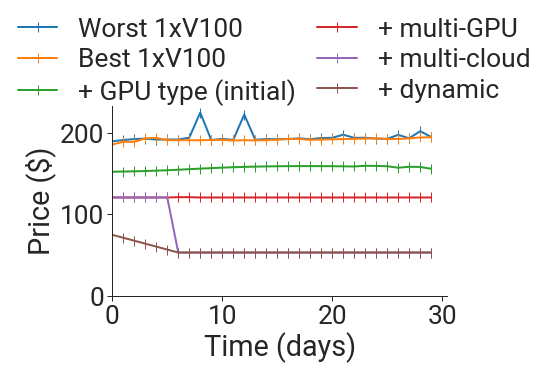

Transformer (batch size 256)
baseline_worst	195.50	189.90	225.13
baseline	191.88	185.94	194.94
gpu_type	191.88	185.94	194.94
packed	171.92	171.90	172.28
multi_cloud	81.65	49.48	171.90
preemption	55.31	49.48	82.18


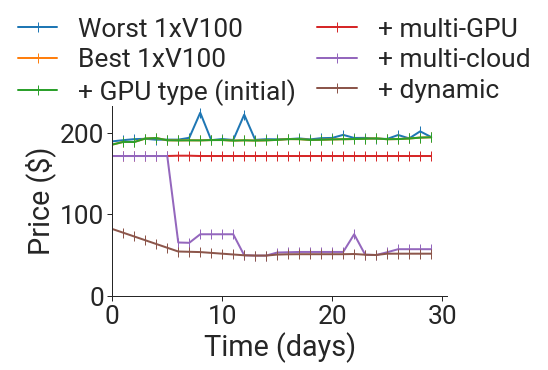

		A3C	CycleGAN	LM (batch size 80)	Recommendation (batch size 8192)	ResNet-50 (batch size 128)	Transformer (batch size 256)
baseline	1.00	1.00	1.00	1.00	1.00	1.00
gpu_type	1.32	1.00	1.00	1.01	1.00	1.00
packed	1.72	1.09	1.09	1.32	1.09	1.12
multi_cloud	3.12	1.56	1.72	2.39	1.50	2.35
preemption	3.72	1.72	1.91	2.88	1.58	3.47


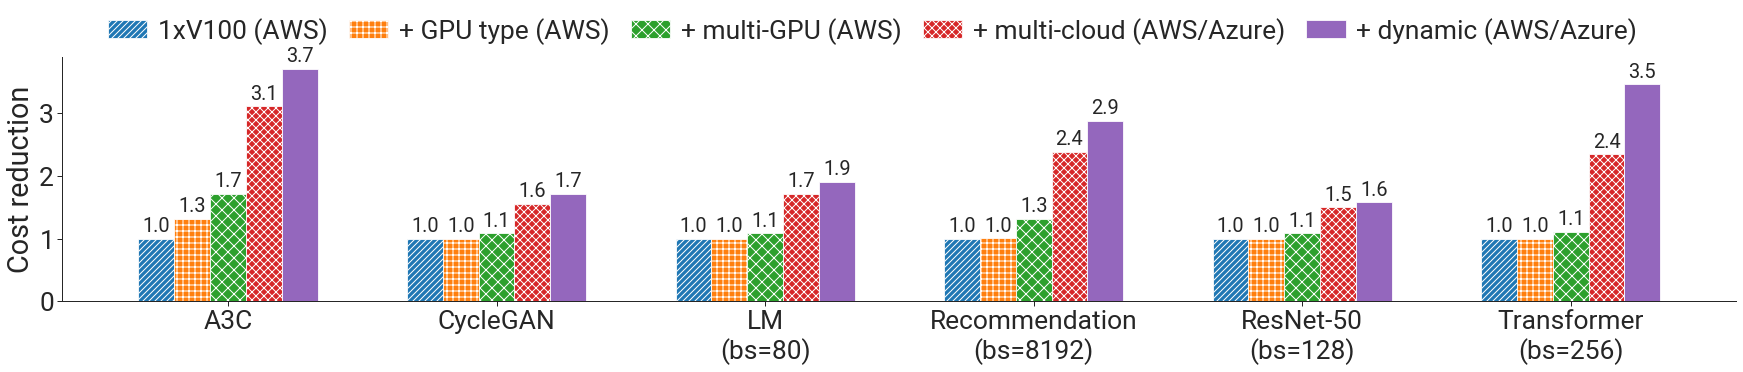

In [8]:
price_statistics = plot_prices(utils.read_aws_prices("../logs/aws/cost/us-east-1", summary=False),
                               utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down"),
                               utils.read_azure_prices("../logs/azure/cost"),
                               num_days=8,
                               output_directory="../graphs/single_job_cost_analysis/per_model_over_time/us_east_1")
model_labels = ['A3C', 'CycleGAN',
                'LM\n(batch size 80)',
                'Recommendation\n(batch size 8192)',
                  'ResNet-50\n(batch size 128)',
                  'Transformer\n(batch size 256)']
plot_bar_chart(price_statistics, model_labels, strategies)

A3C
baseline_worst	102.64	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	56.02	55.73	56.78
packed	55.95	55.73	56.78
multi_cloud	30.93	24.54	56.75
preemption	27.08	24.54	46.30


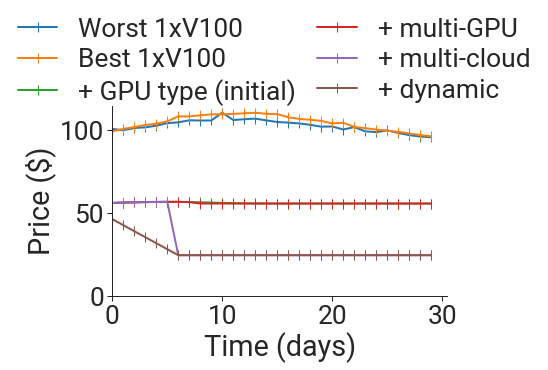

CycleGAN
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	104.63	96.34	110.59
packed	92.06	88.13	97.26
multi_cloud	62.99	49.73	93.46
preemption	58.72	49.73	91.71


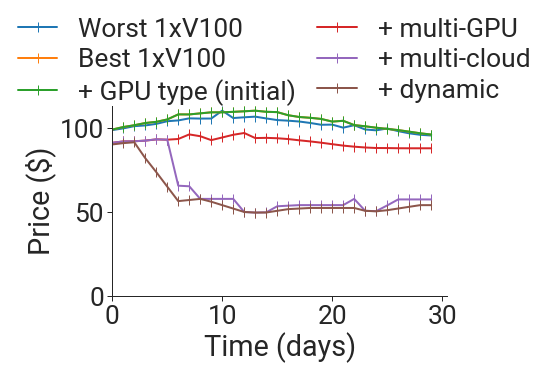

LM (batch size 40)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	104.63	96.34	110.59
packed	92.06	88.13	97.26
multi_cloud	57.24	41.50	93.46
preemption	53.51	41.50	91.71


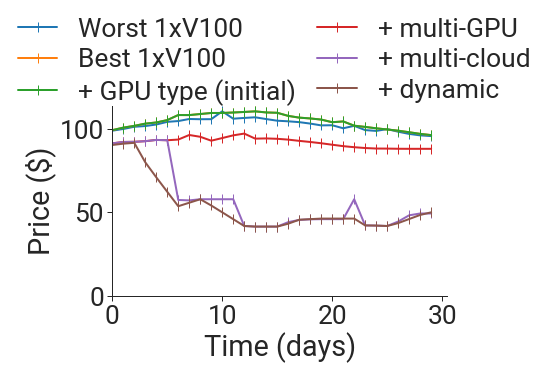

LM (batch size 80)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	104.63	96.34	110.59
packed	92.06	88.13	97.26
multi_cloud	57.02	41.20	93.46
preemption	53.31	41.20	91.71


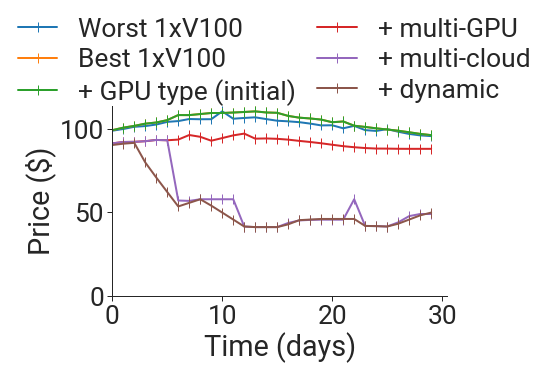

Recommendation (batch size 8192)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	73.08	72.74	73.80
packed	73.00	72.74	73.80
multi_cloud	40.37	32.03	73.80
preemption	34.57	32.03	53.79


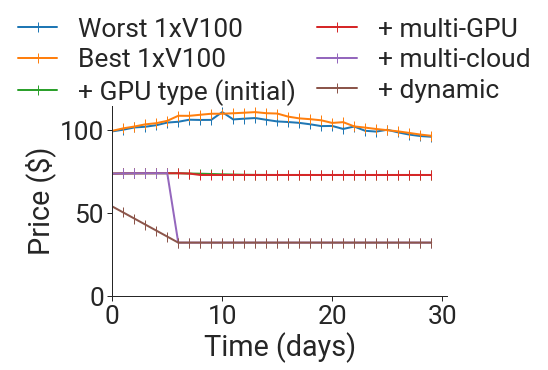

ResNet-18 (batch size 16)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	104.63	96.34	110.59
packed	92.06	88.13	97.26
multi_cloud	55.82	41.55	93.46
preemption	50.08	41.55	91.71


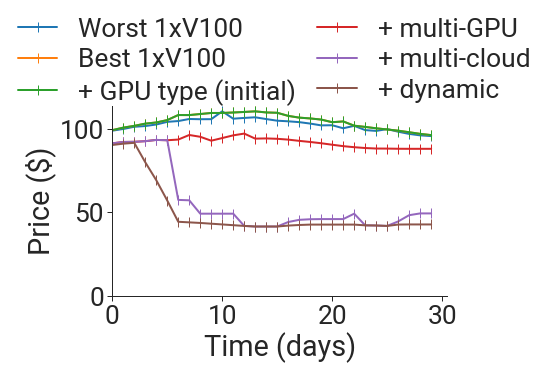

ResNet-18 (batch size 256)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	104.63	96.34	110.59
packed	92.06	88.13	97.26
multi_cloud	57.77	42.27	93.46
preemption	54.01	42.27	91.71


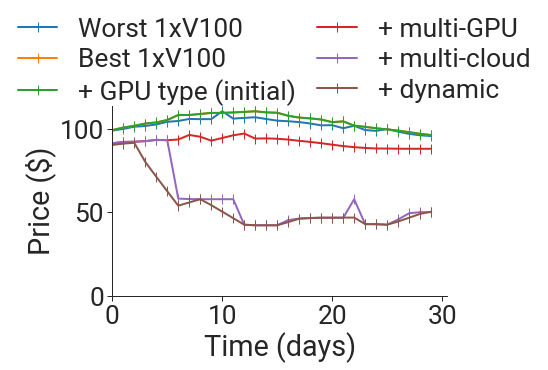

ResNet-50 (batch size 128)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	104.63	96.34	110.59
packed	92.06	88.13	97.26
multi_cloud	64.83	57.90	93.46
preemption	62.94	57.90	91.71


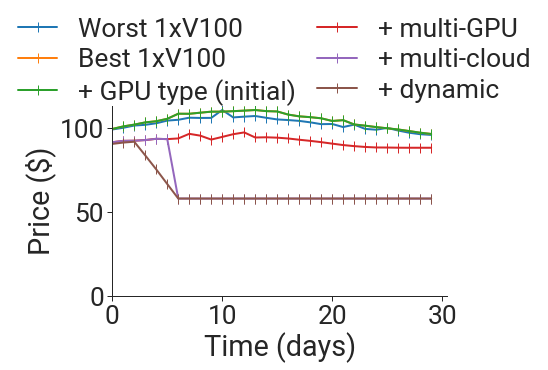

ResNet-50 (batch size 16)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	104.63	96.34	110.59
packed	92.06	88.13	97.26
multi_cloud	65.28	53.01	93.46
preemption	60.65	53.01	91.71


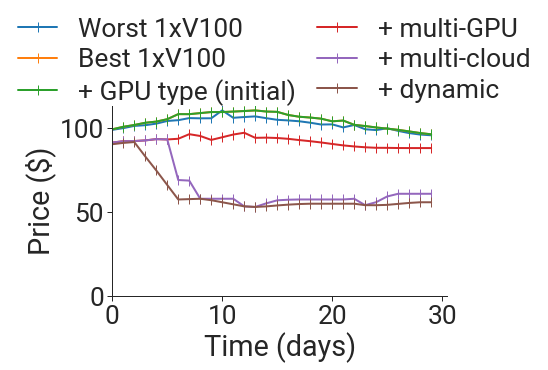

Transformer (batch size 16)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	60.72	60.41	61.47
packed	60.64	60.41	61.47
multi_cloud	33.53	26.60	61.45
preemption	29.14	26.60	48.36


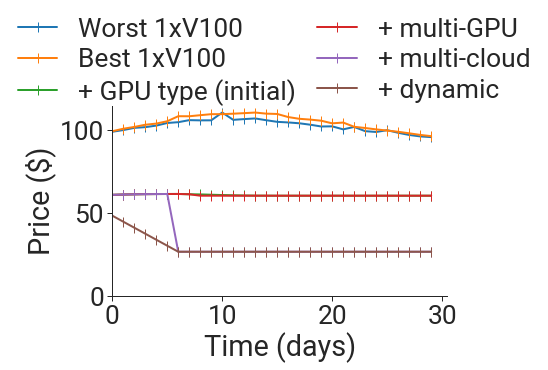

Transformer (batch size 256)
baseline_worst	102.58	95.77	110.60
baseline	104.63	96.34	110.59
gpu_type	86.30	85.95	87.01
packed	86.22	85.95	87.01
multi_cloud	40.65	24.74	87.01
preemption	29.72	24.74	53.76


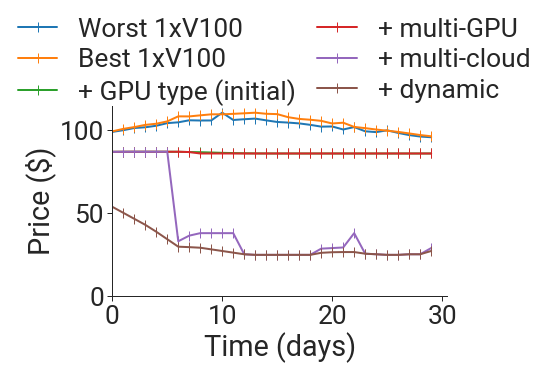

		A3C	CycleGAN	LM (batch size 80)	Recommendation (batch size 8192)	ResNet-50 (batch size 128)	Transformer (batch size 256)
baseline	1.00	1.00	1.00	1.00	1.00	1.00
gpu_type	1.87	1.00	1.00	1.43	1.00	1.21
packed	1.87	1.14	1.14	1.43	1.14	1.21
multi_cloud	3.38	1.66	1.83	2.59	1.61	2.57
preemption	3.86	1.78	1.96	3.03	1.66	3.52


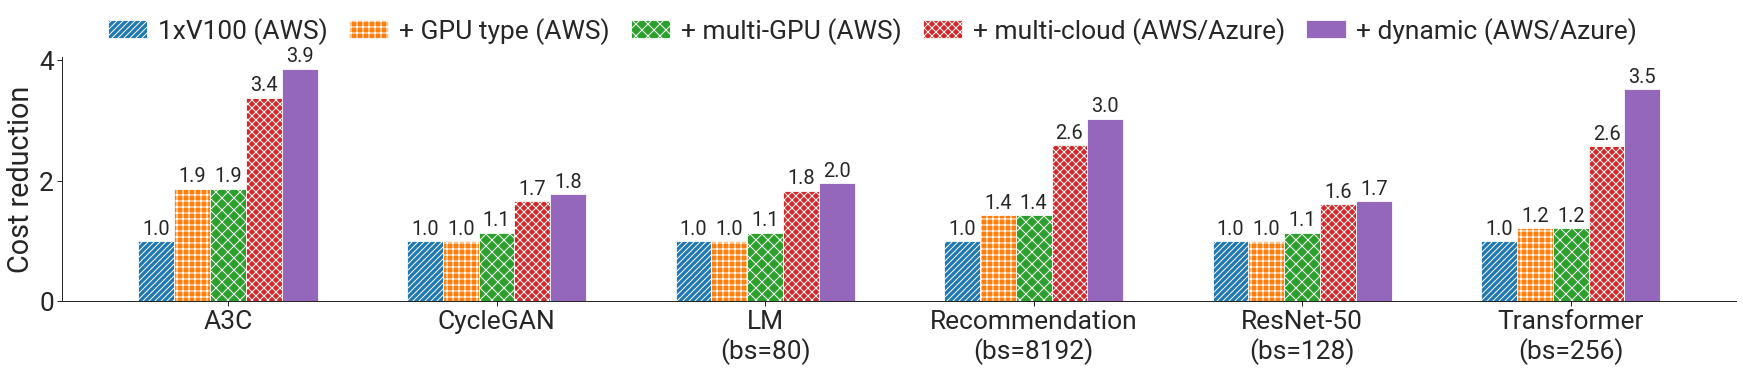

In [9]:
price_statistics = plot_prices(utils.read_aws_prices("../logs/aws/cost/us-west-2", summary=False),
                               utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down"),
                               utils.read_azure_prices("../logs/azure/cost"),
                               num_days=4,
                               output_directory="../graphs/single_job_cost_analysis/per_model_over_time/us_west_2")
model_labels = ['A3C', 'CycleGAN',
                'LM\n(batch size 80)',
                'Recommendation\n(batch size 8192)',
                  'ResNet-50\n(batch size 128)',
                  'Transformer\n(batch size 256)']
plot_bar_chart(price_statistics, model_labels, strategies,
               output_filename="../graphs/single_job_cost_analysis/average_cost_reduction/us_west_2.pdf")

A3C
baseline_worst	207.43	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	111.81	111.46	112.52
packed	111.74	111.46	112.52
multi_cloud	61.77	49.08	112.52
preemption	51.62	49.08	70.84


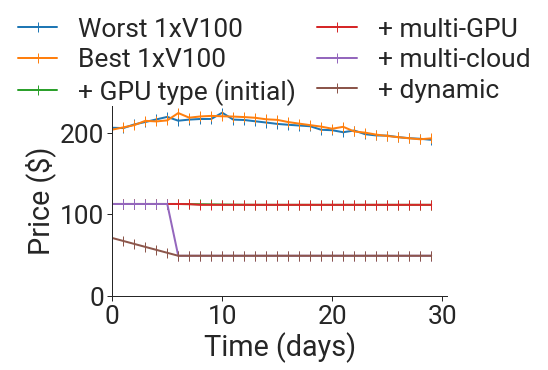

CycleGAN
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	209.06	191.78	223.93
packed	184.59	176.26	199.51
multi_cloud	125.49	103.91	188.68
preemption	112.34	102.20	164.33


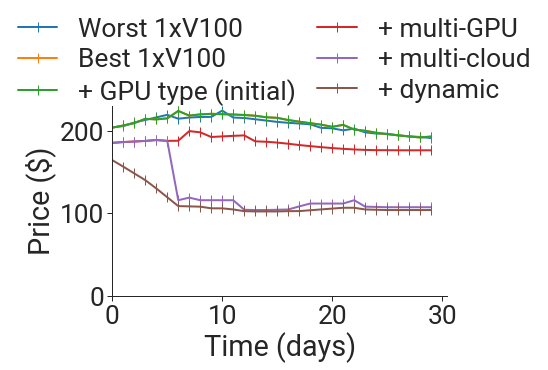

LM (batch size 40)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	209.06	191.78	223.93
packed	184.59	176.26	199.51
multi_cloud	114.24	87.47	188.68
preemption	101.30	87.81	161.48


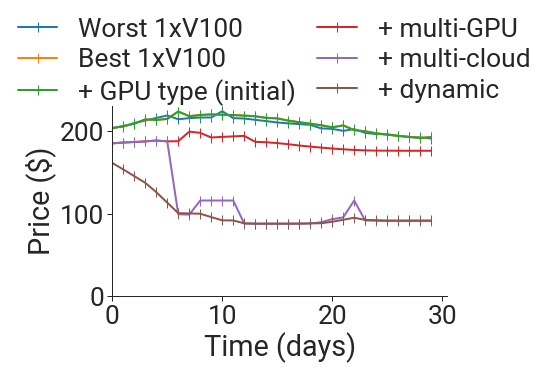

LM (batch size 80)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	209.06	191.78	223.93
packed	184.59	176.26	199.51
multi_cloud	113.84	86.87	188.68
preemption	100.88	87.29	161.35


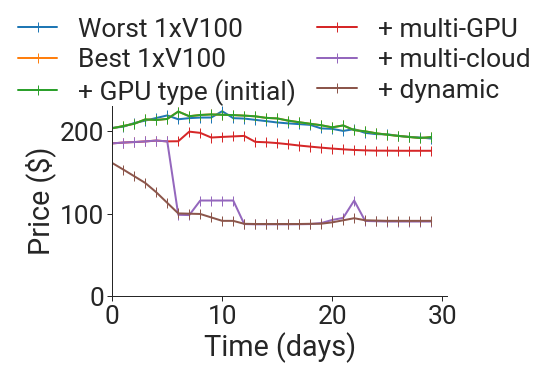

Recommendation (batch size 8192)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	145.84	145.49	146.54
packed	145.76	145.49	146.54
multi_cloud	80.56	64.06	146.54
preemption	66.60	64.06	85.82


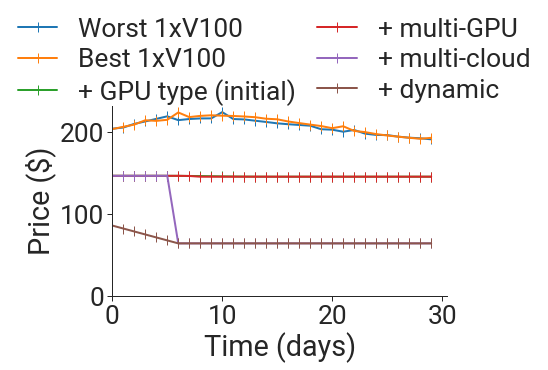

ResNet-18 (batch size 16)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	209.06	191.78	223.93
packed	184.59	176.26	199.51
multi_cloud	111.42	87.56	188.68
preemption	93.91	84.25	159.74


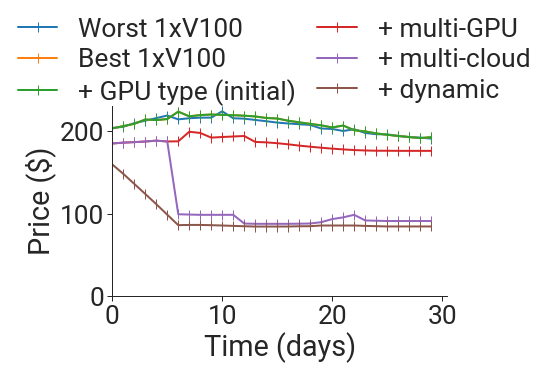

ResNet-18 (batch size 256)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	209.06	191.78	223.93
packed	184.59	176.26	199.51
multi_cloud	115.28	89.00	188.68
preemption	102.36	89.16	161.79


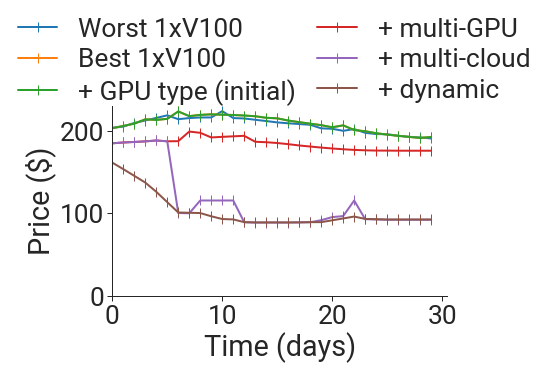

ResNet-50 (batch size 128)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	209.06	191.78	223.93
packed	184.59	176.26	199.51
multi_cloud	130.05	115.80	188.68
preemption	121.71	115.80	165.66


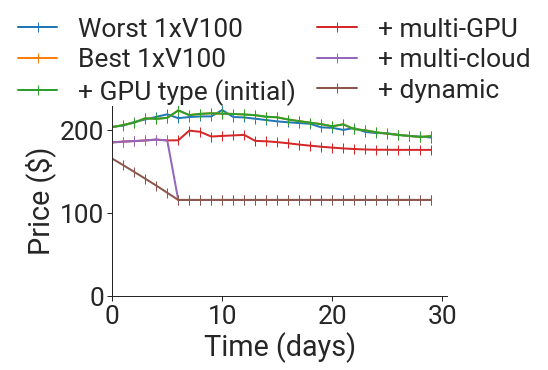

ResNet-50 (batch size 16)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	209.06	191.78	223.93
packed	184.59	176.26	199.51
multi_cloud	130.06	110.53	188.68
preemption	116.52	107.95	165.22


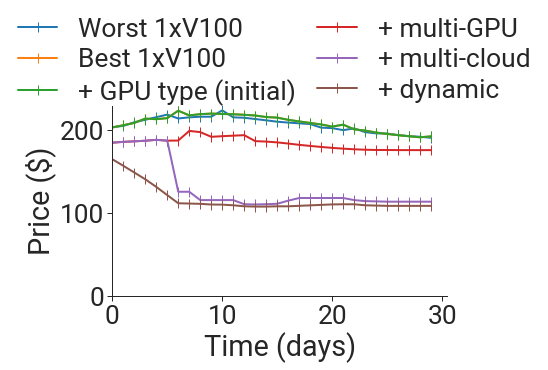

Transformer (batch size 16)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	121.17	120.82	121.88
packed	121.10	120.82	121.88
multi_cloud	66.94	53.20	121.88
preemption	55.74	53.20	74.96


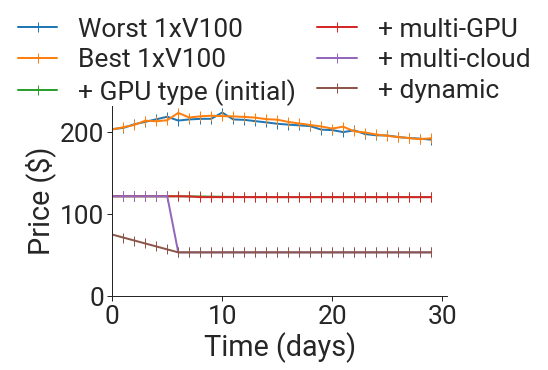

Transformer (batch size 256)
baseline_worst	207.37	191.14	224.33
baseline	209.06	191.78	223.93
gpu_type	172.25	171.90	172.95
packed	172.17	171.90	172.95
multi_cloud	81.86	49.48	172.95
preemption	55.31	49.48	82.18


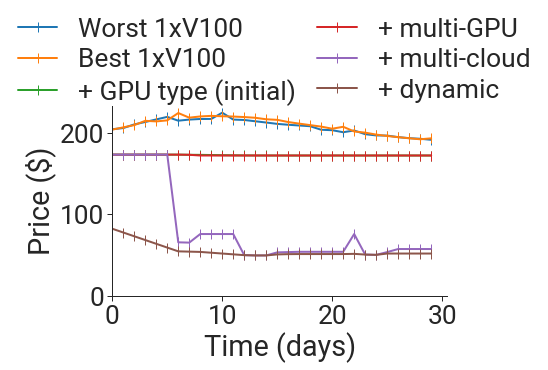

		A3C	CycleGAN	LM (batch size 80)	Recommendation (batch size 8192)	ResNet-50 (batch size 128)	Transformer (batch size 256)
baseline	1.00	1.00	1.00	1.00	1.00	1.00
gpu_type	1.87	1.00	1.00	1.43	1.00	1.21
packed	1.87	1.13	1.13	1.43	1.13	1.21
multi_cloud	3.38	1.67	1.84	2.60	1.61	2.55
preemption	4.05	1.86	2.07	3.14	1.72	3.78


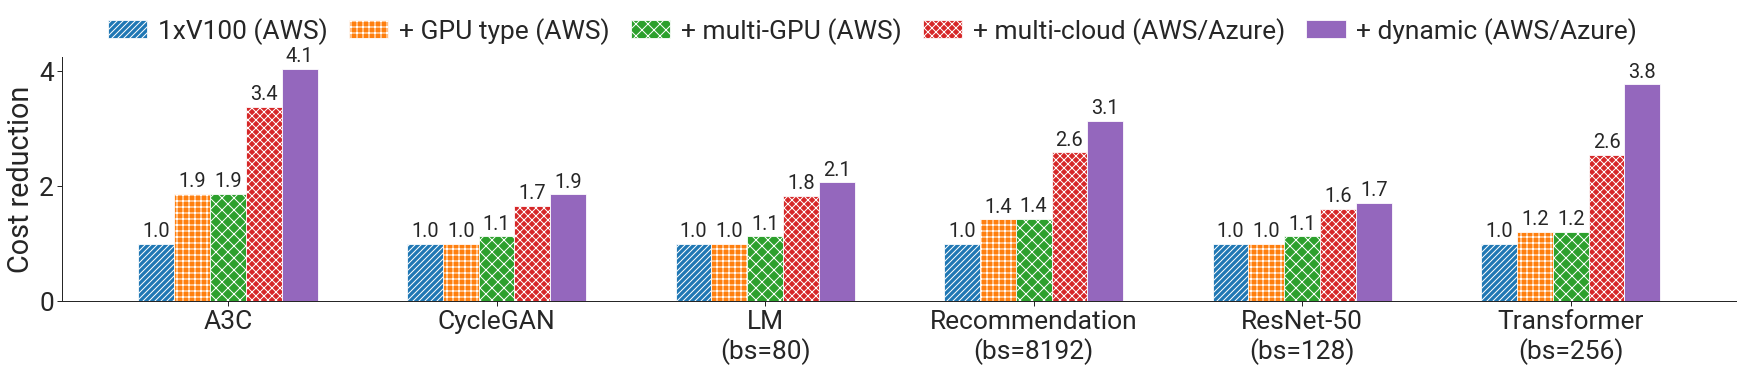

In [10]:
price_statistics = plot_prices(utils.read_aws_prices("../logs/aws/cost/us-west-2", summary=False),
                               utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down"),
                               utils.read_azure_prices("../logs/azure/cost"),
                               num_days=8)
model_labels = ['A3C', 'CycleGAN',
                'LM\n(batch size 80)',
                'Recommendation\n(batch size 8192)',
                  'ResNet-50\n(batch size 128)',
                  'Transformer\n(batch size 256)']
plot_bar_chart(price_statistics, model_labels, strategies)

# Plot cost reduction with duration of job

In [11]:
import pandas as pd
import matplotlib.ticker as mticker

def plot_cost_reduction_with_preemption(aws_per_instance_type_spot_prices,
                                        gcp_per_instance_type_spot_prices,
                                        azure_per_instance_type_spot_prices,
                                        all_num_days,
                                        output_filename=None,
                                        verbose=False):
    all_timestamps = []
    for instance_type in aws_per_instance_type_spot_prices:
        all_timestamps.extend(
            [x['Timestamp']
             for x in aws_per_instance_type_spot_prices[instance_type]])
    all_timestamps.sort()
    first_timestamp = all_timestamps[0]
    
    model_mapping = {
        'A3C': 'A3C',
        'CycleGAN': 'CycleGAN',
        'LM (batch size 80)': 'LM',
        'Recommendation (batch size 8192)': 'Recommendation',
        'ResNet-18 (batch size 256)': 'ResNet-18',
        'ResNet-50 (batch size 128)': 'ResNet-50',
        'Transformer (batch size 256)': 'Transformer'
    }
    
    plt.figure(figsize=(12.5, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    markers = ['o', 's', '^', 'D']
    
    price_statistics = {}
    models = ['A3C', 'ResNet-50 (batch size 128)',
              'Transformer (batch size 256)']
    for i, model in enumerate(models):
        price_statistics[model] = {}

        instance_type = 'p3.2xlarge'

        timestamps = set()
        for x in aws_per_instance_type_spot_prices[instance_type]:
            timestamps.add(x['Timestamp'])
        timestamps = list(timestamps)
        timestamps.sort()
        timestamps = timestamps[-35:-5]
        first_timestamp = timestamps[0]
    
        all_y = []
        all_x = []
        all_y_list = []
        for timestamp in timestamps:
            y = []
            for num_days in all_num_days:
                if verbose:
                    print("=" * 50)
                    print(model, num_days)
                    print("=" * 50)
                    print(model, 'multi_cloud')
                baseline_price = get_price(
                    'multi_cloud',
                    num_days=num_days,
                    aws_per_instance_type_spot_prices=aws_per_instance_type_spot_prices,
                    gcp_per_instance_type_spot_prices=gcp_per_instance_type_spot_prices,
                    azure_per_instance_type_spot_prices=azure_per_instance_type_spot_prices,
                    model=model,
                    start_timestamp=timestamp,
                    verbose=verbose)
                if verbose:
                    print()
                    print(model, 'preemption')
                preemptive_price = get_price(
                    'preemption',
                    num_days=num_days,
                    aws_per_instance_type_spot_prices=aws_per_instance_type_spot_prices,
                    gcp_per_instance_type_spot_prices=gcp_per_instance_type_spot_prices,
                    azure_per_instance_type_spot_prices=azure_per_instance_type_spot_prices,
                    model=model,
                    start_timestamp=timestamp,
                    verbose=verbose)
                y.append(baseline_price / preemptive_price)
                if verbose:
                    print("Cost reduction: %.2f" % (baseline_price / preemptive_price))
                    print()
        
            all_y.extend(y)
            all_y_list.append(y)
            all_x.extend(all_num_days)
        np.set_printoptions(precision=2)
        print(model, np.mean(all_y_list, axis=0))
        df = pd.DataFrame(list(zip(all_x, all_y)), 
            columns =['Duration', 'Cost reduction'])
        sns.lineplot(data=df, x='Duration', y='Cost reduction',
                     label=model_mapping[model], color=colors[i], legend=False,
                     marker=markers[i], ci=None, markersize=15)

    ax.set_ylabel("Cost reduction")
    ax.set_xlabel("Duration of job on V100 (days; log2)")
    ax.set_ylim([None, 1.5])
    ax.set_xscale('log', basex=2)
    ax.set_xticks([0.125, 0.25, 0.5, 1, 2, 4, 8])
    ax.set_xticklabels([0.125, 0.25, 0.5, 1, 2, 4, 8])
    sns.despine()

    leg = plt.figlegend(ncol=3, frameon=False, labelspacing=0.25,
                        columnspacing=0.8, handlelength=1.5,
                        loc='upper center')

    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    y_offset = 0.13
    bb.y0 += y_offset
    bb.y1 += y_offset
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')

    plt.show()

A3C [1.   1.   1.   1.02 1.05 1.11 1.16]
ResNet-50 (batch size 128) [1.   1.   1.   1.   1.01 1.02 1.05]
Transformer (batch size 256) [1.   1.   1.02 1.07 1.17 1.28 1.41]


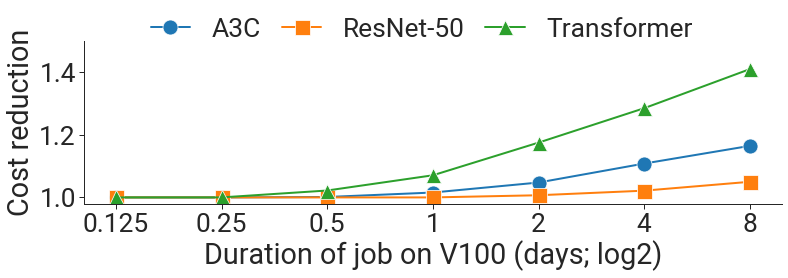

In [12]:
plot_cost_reduction_with_preemption(utils.read_aws_prices("../logs/aws/cost/us-east-1", summary=False),
                                    utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down"),
                                    utils.read_azure_prices("../logs/azure/cost"),
                                    all_num_days=[0.125, 0.25, 0.5, 1, 2, 4, 8],
                                    output_filename="../graphs/single_job_cost_analysis/cost_reduction_vs_duration/us_east_1.pdf")